In [1]:
from __future__ import division
from pycog import tasktools
import numpy as np

These RNNs have three layers (one could make more...) of time-varying "neurons": input units $\vec{u}(t)$, recurrent (hidden) units $\vec{r}(t)$, and output units $\vec{z}(t)$. The dynamics of the recurrent units are given by:
$$ \tau\frac{d\vec{x}}{dt} = -\vec{x} + W^{rec}\vec{r} + W^{in}\vec{u} + \sqrt{2\tau\sigma^{2}_{rec}}\vec{\xi} $$
$$ \vec{r} = [\vec{x}]_{+} $$
$$ \vec{z} = W^{out}\vec{r} $$
where $\vec{\xi}$ is a vector of independent gaussian RVs, and $[.]_{+}$ is the rectification function. 

First, let's decide that task that we want the network to perform. Let's start with something simple. How about a discrimination task? We want the network to signal via one output neuron if the input is less than some threshold $t$ and signal via a different output neuron if the input is greater than that value. To be clear, we have an input $x$ and two outputs $\vec{y}$, $y_{1}$ and $y_{2}$, we want our network to perform the function $f$, as in $\vec{y} = f(x)$, with $f$ defined as,

$ f(x) = 
\begin{cases}
[0, r]^{T} & x > t \\
[r, 0]^{T} & x \leq t
\end{cases}
$ 

Let's decide what kind of network we want to use first. Two things are immediately clear: we only need one input and two output neurons. 

How many neurons do we want for the hidden layer? 

In [2]:
# network details
nin = 1
n = 20
nout = 2

ei, exc, inh = tasktools.generate_ei(n)
ne = len(exc)
ni = len(inh)

# input
visual_input = 0 # label for the input index, we might want to add more later!
visual_exc = exc # all excitatory neurons in the hidden layer will receive visual input
# but note that the hidden units will not
cin = np.zeros((n, nin))
cin[visual_exc, visual_input] = 1
baseline_input = .2 # noise

# output
left_resp = 0
right_resp = 1
cout = np.zeros((nout, n))
cout[:, exc] = 1 # output neurons both receive from all exc neurons

hi_resp = 1
lo_resp = 0

In [3]:
x = np.arange(8)
y = x
print y


[0 1 2 3 4 5 6 7]


Okay, so we have a fairly clear trial structure. We want to choose $t$ such that $t$ is in the set of possible $x$ and then train the network to make the correct discrimination by giving it the correct output vector in training. This is done by the "generate_trial" function. First, let's consider how many conditions we have:
1. $x > t \rightarrow [0, r]^{T}$
2. $x \leq t \rightarrow [r, 0]^{T}$

Do we want anything else?

Something that appears to be useful in training is to assert the stimulus dependence of the network, by inserting trials on which the network is required to not robustly respond, that is, catch trials. 

The generate_file function has a strict input and output contract, but uses closures to store lots of variables declared globally before it. 

In [4]:
dt = 20 # ms, we don't need to integrate with too much precision, especially for training -- we can plot with
        # higher resolution
tau = 100

thresh = 10. # where's the discrimination boundary?
x_std = 5. # let's give it a somewhat large spread

fixation = 500
sample = 400
decision = 300
T = fixation + sample + decision
epochs = {'fixation':(0, fixation),
          'stimulus':(fixation, fixation + sample),
          'decision':(fixation + sample, T),
          'T':T}

upperbound = thresh*2.
scale_x = lambda x: max(min(x, upperbound), 0.)/upperbound
# we don't need to declare rng or params here, but we do need to give "generate_trial" everything 
# else it needs to generate a "trial" structure in the two conditions we've described
def generate_trial(rng, dt, params):
    sample_x  = rng.randn()*x_std + thresh
    sc_x = scale_x(sample_x)
    t, e = tasktools.get_epochs_idx(dt, epochs)
    trial = {'t':t, 'epochs':epochs}
    
    X = np.zeros((len(t), nin))
    X[e['stimulus'], :] = sc_x
    trial['inputs'] = X
    
    if sample_x > thresh:
        choice = 1
    else:
        choice = 0
    Y = np.zeros((len(t), nout))
    M = np.zeros_like(Y)
    Y[e['fixation'], :] = lo_resp
    Y[e['decision'], choice] = hi_resp
    Y[e['decision'], 1-choice] = lo_resp
    M[e['fixation']+e['decision'], :] = 1
    trial['outputs'] = Y
    trial['mask'] = M
        
    trial['info'] = {'input': sample_x, 'scaled_input':sc_x, 'choice': choice}
    return trial


Now, let's decide how we'll evaluate the performance of our network and when we'll tell our network to stop training.

In [5]:
# there are several ready-made performance metrics in the tasktools file, this is a two
# alternative forced choice task, so let's use that one
performance = tasktools.performance_2afc

# termination criterion
target_performance = 90
def terminate(performance_history):
    return np.mean(performance_history[-5:]) > target_performance

nconds = 2
n_validation = 100*nconds

All right, now we have all of the pieces that we need. Let's construct and then train the model. So far, we've had to do a lot of the work, now pycog will take over from us. 

In [6]:
from pycog import Model

model = Model(N=n, Nout=nout, Nin=nin, ei=ei, tau=tau, dt=dt,
              generate_trial=generate_trial, n_validation=n_validation, terminate=terminate,
              performance=performance)

In [10]:
seed = np.random.randint(0, 1000000)
model.train('test.pkl', seed=seed, recover=False)

=> settings
   | GPU:                       enabled
   | init seed:                 418236
   | distribution (Win):        uniform
   | distribution (Wrec):       gamma
   | distribution (Wout):       uniform
   | Nin/N/Nout:                1/20/2
   | Dale's law:                E/I = 16/4
   | initial spectral radius:   1.50
   | train recurrent bias:      no
   | train output bias:         no
   | train initial conditions:  yes
   | sparseness (Wrec):         p = 0.95, p_plastic = 0.95
   | E/I positivity function:   rectify
   | hidden activation:         rectify
   | output activation/loss:    linear/squared
   | mode:                      batch
   | output mask:               yes
   | sigma_in:                  0.01
   | sigma_rec:                 0.15
   | rectify inputs:            True
   | gradient minibatch size:   20
   | validation minibatch size: 200
   | dt:                        20 ms
   | tau:                       100 ms
   | tau_in:                    100 ms
   | lea

In [11]:
from pycog import RNN
plot_dt = 1
#rnn = RNN('ramping_pathology.pkl', {'dt':plot_dt})
rnn = RNN('test.pkl', {'dt':plot_dt})

[ pycog.rnn.RNN ] 10000 updates, best error = 0.29905233, spectral radius = 1.56590736


=> settings
   | dt:        1 ms
   | threshold: 0.0001
{'epochs': {'fixation': (0, 500), 'stimulus': (500, 900), 'decision': (900, 1200), 'T': 1200}, 'input': 10.615574670494492, 'scaled_input': 0.5307787335247246, 'choice': 1}


Text(0,0.5,'activity')

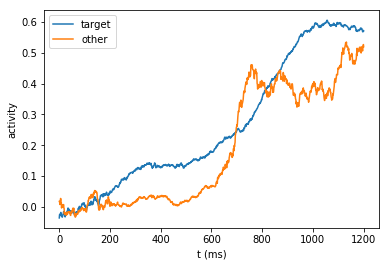

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
info = rnn.run(inputs=(generate_trial, {}), seed=np.random.randint(0, 10000))
print info
f = plt.figure()
corr_choice = info['choice']
ax = f.add_subplot(1, 1, 1)
ax.plot(rnn.t, rnn.z[corr_choice], label='target')
ax.plot(rnn.t, rnn.z[1 - corr_choice], label='other')
ax.legend()
ax.set_xlabel('t (ms)')
ax.set_ylabel('activity')

=> settings
   | dt:        1 ms
   | threshold: 0.0001
None


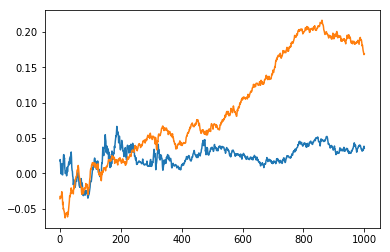

In [13]:
run_t = 1000

f = plt.figure()
ax = f.add_subplot(1, 1, 1)
info = rnn.run(T=run_t, seed=np.random.randint(0, 10000))
print info
ax.plot(rnn.t, rnn.z[0], label='0')
ax.plot(rnn.t, rnn.z[1], label='1')

This looks good, but hmmm, this ramping is a little bit annoying. We should do something more to constrain both output neurons to not respond unless it's the right stimulus. Let's reconsider our trial function. We want to add a third condition, in which the neurons are constrained to fire at as low a rate as possible, and in which there is no stimulus given. 

In [14]:
catch_prob = 1/3.
catch_len = 2000

def generate_trial_with_catch(rng, dt, params):
    cp = params.get('catch_prob', catch_prob)
    sc_x = params.get('samp_x',scale_x(rng.randn()*x_std + thresh))
    if rng.rand() < cp:
        epochs = {'T':catch_len}
        t, e = tasktools.get_epochs_idx(dt, epochs)
        trial = {'t':t, 'epochs':epochs}
        trial['info'] = {}
        trial['inputs'] = np.zeros((len(t), nin))
        trial['outputs'] = np.zeros((len(t), nout)) + lo_resp
        trial['mask'] = np.ones_like(trial['outputs'])
    else:
        fixation = 500
        sample = 400
        decision = 300
        T = fixation + sample + decision
        epochs = {'fixation':(0, fixation),
                  'stimulus':(fixation, fixation + sample),
                  'decision':(fixation + sample, T),
                  'T':T}
        # sc_x = scale_x(sample_x)
        t, e = tasktools.get_epochs_idx(dt, epochs)
        trial = {'t':t, 'epochs':epochs}
    
        X = np.zeros((len(t), nin))
        X[e['stimulus'], :] = sc_x
        trial['inputs'] = X
    
        if sc_x > (thresh/upperbound):
            choice = 1
        else:
            choice = 0
        Y = np.zeros((len(t), nout))
        M = np.zeros_like(Y)
        Y[e['fixation'], :] = lo_resp
        Y[e['decision'], choice] = hi_resp
        Y[e['decision'], 1-choice] = lo_resp
        M[e['fixation']+e['decision'], :] = 1
        trial['outputs'] = Y
        trial['mask'] = M
        
        trial['info'] = {'scaled_input':sc_x, 'choice': choice}
    return trial

model = Model(N=n, Nout=nout, Nin=nin, ei=ei, tau=tau, dt=dt,
              generate_trial=generate_trial_with_catch, n_validation=n_validation, 
              terminate=terminate, performance=performance)

In [15]:
seed = np.random.randint(0, 1000000)
model.train('test_ps.pkl', seed=seed, recover=False)

=> settings
   | GPU:                       enabled
   | init seed:                 63415
   | distribution (Win):        uniform
   | distribution (Wrec):       gamma
   | distribution (Wout):       uniform
   | Nin/N/Nout:                1/20/2
   | Dale's law:                E/I = 16/4
   | initial spectral radius:   1.50
   | train recurrent bias:      no
   | train output bias:         no
   | train initial conditions:  yes
   | sparseness (Wrec):         p = 0.95, p_plastic = 0.95
   | E/I positivity function:   rectify
   | hidden activation:         rectify
   | output activation/loss:    linear/squared
   | mode:                      batch
   | output mask:               yes
   | sigma_in:                  0.01
   | sigma_rec:                 0.15
   | rectify inputs:            True
   | gradient minibatch size:   20
   | validation minibatch size: 200
   | dt:                        20 ms
   | tau:                       100 ms
   | tau_in:                    100 ms
   | lear

In [16]:
from pycog import RNN
plot_dt = 1
rnn = RNN('ramping_treated_wcheck.pkl', {'dt':plot_dt}, verbose=False)

[ pycog.rnn.RNN ] File ramping_treated_wcheck.pkl doesn't exist.


SystemExit: 1

/home/hanyu/anaconda2/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
run_t = 1000

f = plt.figure()
ax = f.add_subplot(1, 1, 1)
info = rnn.run(T=run_t, seed=np.random.randint(0, 10000))
ax.plot(rnn.t, rnn.z[0], label='0')
ax.plot(rnn.t, rnn.z[1], label='1')
plt.imshow(rnn.Wrec)
plt.axis()

In [ ]:
import sys

trial_print = """=> settings | dt:        1 ms | threshold: 0.0001"""
def gen_trial(rnn, tfunc, params={}, seed_lim=10000000, suppress_out=True):
    info = rnn.run(inputs=(tfunc, params), seed=np.random.randint(0, seed_lim))
    if suppress_out:
        sys.stdout.write(len(trial_print)*'\b')
        sys.stdout.flush()
    return rnn.t, rnn.r, rnn.z, info

def single_trial_2afcperf(act, info):
    nc = np.argmax(act[:, -1])
    corr = nc == info['choice']
    return corr

def gen_many_trials(rnn, tfunc, n=1, params={}, seed_lim=10000000, perf=None):
    if perf is not None:
        corr = np.zeros(n)
    else:
        corr = None
    for i in xrange(n):
        ts, rs, zs, info = gen_trial(rnn, tfunc, params, seed_lim)
        if i == 0:
            allrs = np.zeros((n, len(rs), len(ts)))
            allzs = np.zeros((n, len(zs), len(ts)))
            allinfo = []
        allrs[i] = rs
        allzs[i] = zs
        allinfo.append(info)
        if perf is not None:
            corr[i] = perf(zs, info)
    return ts, allrs, allzs, allinfo, corr
    
def gen_and_plot_output(rnn, tfunc, params={}, seed_lim=1000000, n=1, perf=None):
    ts, rs, zs, info, corr = gen_many_trials(rnn, tfunc, n, params, seed_lim, perf)
    f = plt.figure()
    corr_choice = info['choice']
    ax = f.add_subplot(1, 1, 1)
    ax.set_title('input: {}'.format(info['scaled_input']))
    ax.plot(ts, zs[corr_choice], label='target')
    ax.plot(ts, zs[1 - corr_choice], label='other')
    ax.legend()
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('activity')

In [ ]:
print 'a'*10 
sys.stdout.write('\b'*10 + 'b'*10)

In [ ]:
xs = np.linspace(0, 1, 20)
rates = np.zeros_like(xs)
tn = 100
for i, x in enumerate(xs):
    params = {'catch_prob':0, 'samp_x':x}
    _, _, _, _, corr = gen_many_trials(rnn, generate_trial_with_catch, n=tn, params=params, 
                                       perf=single_trial_2afcperf)
    rates[i] = np.mean(corr)

In [ ]:
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
ax.plot(xs, rates)

Exploring the output units is fine, but they don't tell us anything about what the hidden units are doing -- ie, how the task is actually being solved. Let's examine the hidden units:

In [ ]:
left_state = .2
right_state = .8
n = 100
lpar = {'catch_prob':0, 'samp_x':left_state}
rpar = {'catch_prob':0, 'samp_x':right_state}

ts, lrs, lzs, linfo, _ = gen_many_trials(rnn, generate_trial_with_catch, n=n, params=lpar)
ts, rrs, rzs, rinfo, _ = gen_many_trials(rnn, generate_trial_with_catch, n=n, params=rpar)

In [ ]:
print lrs.shape

Okay, so now what we have is a couple big arrays: One when the stimulus is below the threshold (and the network is reliably sensitive to that) and the other when it's above threshold. Let's do the easiest thing first:

In [ ]:
f = plt.figure(figsize=(10, 10))
ax1 = f.add_subplot(3, 1, 1)
_ = ax1.plot(ts, np.mean(lrs, 0)[exc].T)
_ = ax1.plot(ts, np.mean(lrs, 0)[inh].T, '--')
ax2 = f.add_subplot(3, 1, 2)
_ = ax2.plot(ts, np.mean(rrs, 0)[exc].T)
_ = ax2.plot(ts, np.mean(rrs, 0)[inh].T, '--')
ax3 = f.add_subplot(3, 1, 3)
lcorr, lincorr = np.mean(lzs, 0)
rincorr, rcorr = np.mean(rzs, 0)
_ = ax3.plot(ts, lcorr.T, 'r', ts, lincorr.T, 'b--')
_ = ax3.plot(ts, rincorr.T, 'r--', ts, rcorr.T, 'b')

Well, this isn't very informative. If we squint, we can generate a strategy that appears to be at work: There appears to be a subpopulation that drives the transient dashed red spike, that is then inhibited while otherwise it is simply allowed to grow (albeit more slowly). When it is the correct answer, it does not reach strength triggering inhibition until later on. So, we have an intuition -- how could we show this more concretely? 

In [ ]:
f = plt.figure(figsize=(5, 10))
ax = f.add_subplot(3, 1, 1)
_ = ax.imshow(rnn.Wrec, interpolation='none')
ax.set_title('recurrent weights')
ax2 = f.add_subplot(3, 1, 2)
_ = ax2.imshow(rnn.Wout, interpolation='none')
ax3 = f.add_subplot(3, 1, 3)
_ = ax3.imshow(rnn.Win.T, interpolation='none')
f.tight_layout()
print rnn.Wout

In [ ]:
f = plt.figure(figsize=(10, 10))
ax1 = f.add_subplot(3, 1, 1)
loutmean = np.mean(lrs, 0)[rnn.Wout.sum(0) > .1]
routmean = np.mean(rrs, 0)[rnn.Wout.sum(0) > .1]
_ = ax1.plot(ts, loutmean.T)
ax2 = f.add_subplot(3, 1, 2)
_ = ax2.plot(ts, routmean.T)

What if we sort by average response to an above threshold stimulus?

In [ ]:
print lrs.shape
print epochs

In [ ]:
l_slice = np.mean(lrs[:, :, epochs['stimulus'][0]:epochs['decision'][-1]], 0)
l_selec = np.mean(l_slice, 1)
l_var = np.var(l_slice, 1)

r_slice = np.mean(rrs[:, :, epochs['stimulus'][0]:epochs['decision'][-1]], 0)
r_selec = np.mean(r_slice, 1)
r_var = np.var(r_slice, 1)

d_primes = (l_selec - r_selec)/(np.sqrt(r_var + l_var)/2)
w_sort = np.argsort(d_primes)
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
print np.nan_to_num(d_primes)
ax.hist(np.nan_to_num(d_primes))

In [ ]:
ws = rnn.Wrec
sortedws = ws[w_sort, :][:, w_sort]

f = plt.figure(figsize=(5, 10))
ax = f.add_subplot(1, 1, 1)
_ = ax.imshow(sortedws, interpolation='none')
ax.set_title('recurrent weights')